<a href="https://colab.research.google.com/github/matrix-mayank/cs229-final-project/blob/main/Intersectional_Fairness_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Loading and preprocessing data...
Data shape: X=(4424, 34), S1=(4424,), S2=(4424,), y=(4424,)
Gender distribution: [2868 1556]
Displaced distribution: [1998 2426]
Target distribution: [1421 2209  794]

Training unfair model...
Epoch 10/50:
Validation Accuracy: 75.82%
Gender Demographic Parity: 0.1390
Displaced Demographic Parity: 0.1077
Intersectional Demographic Parity: 0.2192

Epoch 20/50:
Validation Accuracy: 76.61%
Gender Demographic Parity: 0.1478
Displaced Demographic Parity: 0.1111
Intersectional Demographic Parity: 0.2313

Epoch 30/50:
Validation Accuracy: 76.16%
Gender Demographic Parity: 0.1426
Displaced Demographic Parity: 0.1132
Intersectional Demographic Parity: 0.2307

Epoch 40/50:
Validation Accuracy: 75.93%
Gender Demographic Parity: 0.1437
Displaced Demographic Parity: 0.1097
Intersectional Demographic Parity: 0.2282

Epoch 50/50:
Validation Accuracy: 75.93%
Gender Demographic Parity: 0.1444
Displaced Demographic Parity: 0.1119
Intersectional Demograp

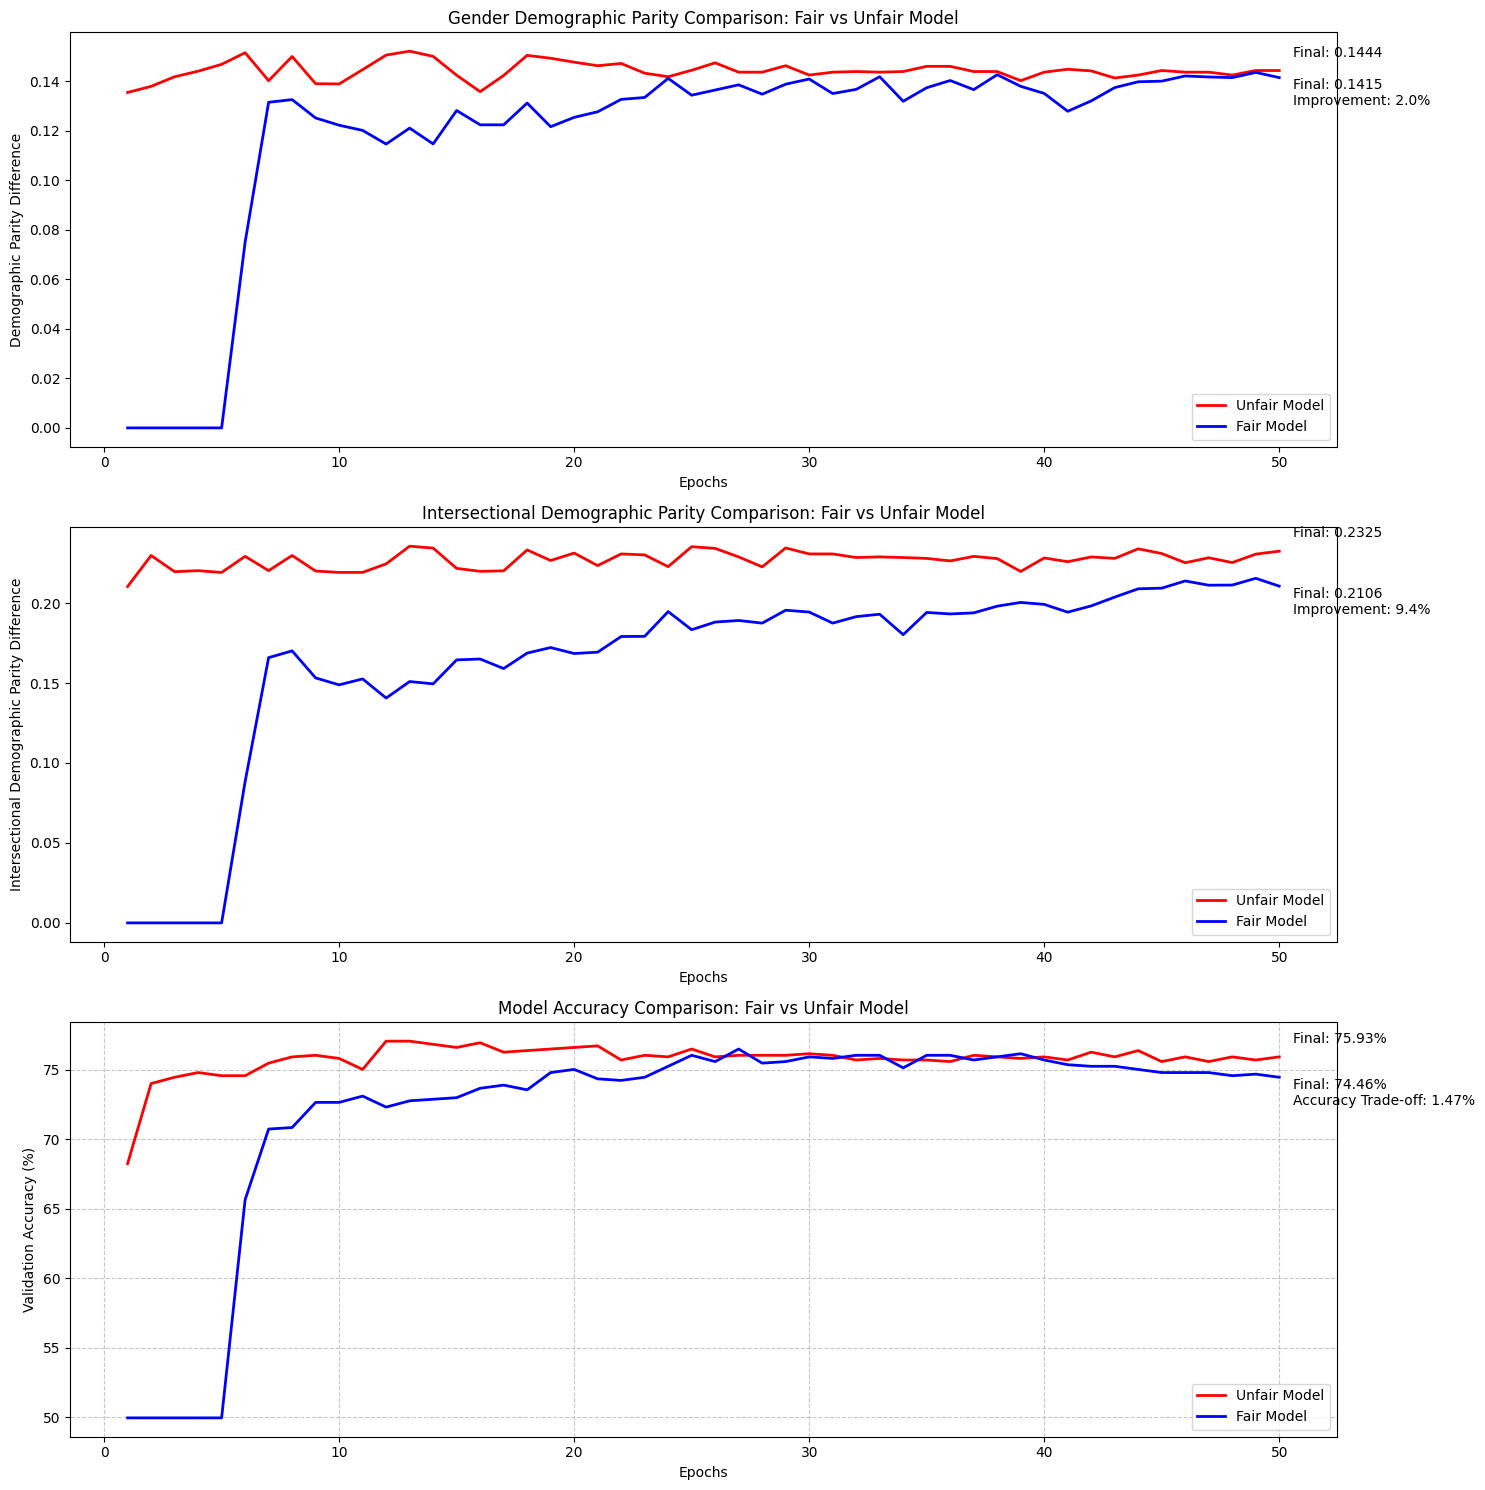

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

class FairnessMetrics:
    @staticmethod
    def calculate_demographic_parity(predictions, sensitive_attributes, positive_label=1):
        """
        Calculate demographic parity difference.
        Demographic parity difference = |P(Y=1|S=0) - P(Y=1|S=1)|
        """
        group_0_mask = sensitive_attributes == 0
        group_1_mask = sensitive_attributes == 1

        pred_positive_rate_0 = (predictions[group_0_mask] == positive_label).mean()
        pred_positive_rate_1 = (predictions[group_1_mask] == positive_label).mean()

        return abs(pred_positive_rate_0 - pred_positive_rate_1)

    @staticmethod
    def calculate_demographic_parity_for_all_labels(predictions, sensitive_attributes, num_classes=3):
        """
        Calculate demographic parity difference for all possible outcome labels.
        Returns the average difference across all outcome classes.
        """
        total_diff = 0
        for label in range(num_classes):
            diff = FairnessMetrics.calculate_demographic_parity(predictions, sensitive_attributes, label)
            total_diff += diff

        return total_diff / num_classes

    @staticmethod
    def calculate_intersectional_demographic_parity(predictions, sensitive_attr1, sensitive_attr2, positive_label=1):
        """
        Calculate demographic parity difference across intersectional groups.
        Returns the maximum difference between any two groups.
        """
        # Create intersectional groups (4 groups for binary attributes)
        group_00_mask = (sensitive_attr1 == 0) & (sensitive_attr2 == 0)
        group_01_mask = (sensitive_attr1 == 0) & (sensitive_attr2 == 1)
        group_10_mask = (sensitive_attr1 == 1) & (sensitive_attr2 == 0)
        group_11_mask = (sensitive_attr1 == 1) & (sensitive_attr2 == 1)

        # Calculate positive prediction rates for each group
        rates = []
        group_sizes = []
        masks = [group_00_mask, group_01_mask, group_10_mask, group_11_mask]
        group_names = ["Group 00", "Group 01", "Group 10", "Group 11"]

        for i, mask in enumerate(masks):
            if np.sum(mask) > 0:  # Ensure group has samples
                rate = (predictions[mask] == positive_label).mean()
                rates.append(rate)
                group_sizes.append(np.sum(mask))
            else:
                rates.append(0)
                group_sizes.append(0)

        # Calculate maximum difference between any two groups
        max_diff = 0
        max_i, max_j = 0, 0
        for i in range(len(rates)):
            for j in range(i+1, len(rates)):
                if group_sizes[i] > 0 and group_sizes[j] > 0:  # Only compare groups with samples
                    diff = abs(rates[i] - rates[j])
                    if diff > max_diff:
                        max_diff = diff
                        max_i, max_j = i, j

        return max_diff

    @staticmethod
    def calculate_equalized_odds(predictions, sensitive_attributes, true_labels, positive_label=1):
        """
        Calculate equalized odds difference.
        Equalized odds requires P(Y_pred=1|Y=y,S=0) = P(Y_pred=1|Y=y,S=1) for y in {0,1}
        """
        # For Y=1 (positive labels)
        pos_mask = true_labels == positive_label
        pos_group_0_mask = (sensitive_attributes == 0) & pos_mask
        pos_group_1_mask = (sensitive_attributes == 1) & pos_mask

        if np.sum(pos_group_0_mask) > 0 and np.sum(pos_group_1_mask) > 0:
            tpr_0 = (predictions[pos_group_0_mask] == positive_label).mean()
            tpr_1 = (predictions[pos_group_1_mask] == positive_label).mean()
            tpr_diff = abs(tpr_0 - tpr_1)
        else:
            tpr_diff = 0

        # For Y=0 (negative labels)
        neg_mask = true_labels != positive_label
        neg_group_0_mask = (sensitive_attributes == 0) & neg_mask
        neg_group_1_mask = (sensitive_attributes == 1) & neg_mask

        if np.sum(neg_group_0_mask) > 0 and np.sum(neg_group_1_mask) > 0:
            fpr_0 = (predictions[neg_group_0_mask] == positive_label).mean()
            fpr_1 = (predictions[neg_group_1_mask] == positive_label).mean()
            fpr_diff = abs(fpr_0 - fpr_1)
        else:
            fpr_diff = 0

        # Return the maximum violation
        return max(tpr_diff, fpr_diff)

class MetricsTracker:
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []
        self.validation_acc = []
        self.adversarial_loss = []
        self.demographic_parity = []
        self.intersectional_demographic_parity = []
        self.gender_equalized_odds = []
        self.displaced_equalized_odds = []

    def update(self, train_loss, val_loss, val_acc, adv_loss, dem_parity, intersect_parity,
              gender_eq_odds=None, displaced_eq_odds=None):
        self.training_loss.append(train_loss)
        self.validation_loss.append(val_loss)
        self.validation_acc.append(val_acc)
        self.adversarial_loss.append(adv_loss)
        self.demographic_parity.append(dem_parity)
        self.intersectional_demographic_parity.append(intersect_parity)

        if gender_eq_odds is not None:
            self.gender_equalized_odds.append(gender_eq_odds)
        if displaced_eq_odds is not None:
            self.displaced_equalized_odds.append(displaced_eq_odds)

    def plot_metrics(self, is_fair_model=True):
        plt.figure(figsize=(15, 12))

        # Plot 1: Losses and Accuracy
        plt.subplot(3, 2, 1)
        epochs = range(1, len(self.training_loss) + 1)
        plt.plot(epochs, self.training_loss, 'b-', label='Training Loss')
        plt.plot(epochs, self.validation_loss, 'r-', label='Validation Loss')
        plt.plot(epochs, [acc/100 for acc in self.validation_acc], 'g-', label='Validation Accuracy')
        plt.title('Training Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

        # Plot 2: Demographic Parity (Gender)
        plt.subplot(3, 2, 2)
        plt.plot(epochs, self.demographic_parity, 'b-', label='Gender Demographic Parity')
        plt.title('Gender Fairness Metric (Lower is Better)')
        plt.xlabel('Epochs')
        plt.ylabel('Demographic Parity Difference')
        plt.legend()

        # Plot 3: Intersectional Demographic Parity
        plt.subplot(3, 2, 3)
        plt.plot(epochs, self.intersectional_demographic_parity, 'r-', label='Intersectional Demographic Parity')
        plt.title('Intersectional Fairness Metric (Lower is Better)')
        plt.xlabel('Epochs')
        plt.ylabel('Intersectional Demographic Parity Difference')
        plt.legend()

        # Plot 4: Gender Equalized Odds
        if self.gender_equalized_odds:
            plt.subplot(3, 2, 4)
            plt.plot(epochs, self.gender_equalized_odds, 'g-', label='Gender Equalized Odds')
            plt.title('Gender Equalized Odds (Lower is Better)')
            plt.xlabel('Epochs')
            plt.ylabel('Equalized Odds Difference')
            plt.legend()

        # Plot 5: Displaced Equalized Odds
        if self.displaced_equalized_odds:
            plt.subplot(3, 2, 5)
            plt.plot(epochs, self.displaced_equalized_odds, 'm-', label='Displaced Equalized Odds')
            plt.title('Displaced Equalized Odds (Lower is Better)')
            plt.xlabel('Epochs')
            plt.ylabel('Equalized Odds Difference')
            plt.legend()

        # Plot 6: Adversarial Loss (for fair model)
        if is_fair_model:
            plt.subplot(3, 2, 6)
            plt.plot(epochs, self.adversarial_loss, 'c-', label='Adversarial Loss')
            plt.title('Adversarial Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

        plt.tight_layout()
        plt.show()

def compare_models_plot(metrics_unfair, metrics_fair):
    plt.figure(figsize=(15, 15))
    epochs = range(1, len(metrics_unfair.demographic_parity) + 1)

    # Plot 1: Gender Demographic Parity
    plt.subplot(3, 1, 1)
    plt.plot(epochs, metrics_unfair.demographic_parity, 'r-',
             label='Unfair Model', linewidth=2)
    plt.plot(epochs, metrics_fair.demographic_parity, 'b-',
             label='Fair Model', linewidth=2)

    plt.title('Gender Demographic Parity Comparison: Fair vs Unfair Model')
    plt.xlabel('Epochs')
    plt.ylabel('Demographic Parity Difference')
    plt.legend()

    # Calculate improvement percentage
    if metrics_unfair.demographic_parity[-1] > 0:
        improvement = (metrics_unfair.demographic_parity[-1] - metrics_fair.demographic_parity[-1]) / metrics_unfair.demographic_parity[-1] * 100
        improvement_text = f"Improvement: {improvement:.1f}%"
    else:
        improvement_text = ""

    # Add final values annotation
    plt.annotate(f'Final: {metrics_unfair.demographic_parity[-1]:.4f}',
                xy=(epochs[-1], metrics_unfair.demographic_parity[-1]),
                xytext=(10, 10), textcoords='offset points')
    plt.annotate(f'Final: {metrics_fair.demographic_parity[-1]:.4f}\n{improvement_text}',
                xy=(epochs[-1], metrics_fair.demographic_parity[-1]),
                xytext=(10, -20), textcoords='offset points')

    # Plot 2: Intersectional Demographic Parity
    plt.subplot(3, 1, 2)
    plt.plot(epochs, metrics_unfair.intersectional_demographic_parity, 'r-',
             label='Unfair Model', linewidth=2)
    plt.plot(epochs, metrics_fair.intersectional_demographic_parity, 'b-',
             label='Fair Model', linewidth=2)

    plt.title('Intersectional Demographic Parity Comparison: Fair vs Unfair Model')
    plt.xlabel('Epochs')
    plt.ylabel('Intersectional Demographic Parity Difference')
    plt.legend()

    # Calculate improvement percentage for intersectional metric
    if metrics_unfair.intersectional_demographic_parity[-1] > 0:
        improvement = (metrics_unfair.intersectional_demographic_parity[-1] - metrics_fair.intersectional_demographic_parity[-1]) / metrics_unfair.intersectional_demographic_parity[-1] * 100
        improvement_text = f"Improvement: {improvement:.1f}%"
    else:
        improvement_text = ""

    plt.annotate(f'Final: {metrics_unfair.intersectional_demographic_parity[-1]:.4f}',
                xy=(epochs[-1], metrics_unfair.intersectional_demographic_parity[-1]),
                xytext=(10, 10), textcoords='offset points')
    plt.annotate(f'Final: {metrics_fair.intersectional_demographic_parity[-1]:.4f}\n{improvement_text}',
                xy=(epochs[-1], metrics_fair.intersectional_demographic_parity[-1]),
                xytext=(10, -20), textcoords='offset points')

    # Plot 3: Model Accuracy Comparison
    plt.subplot(3, 1, 3)
    plt.plot(epochs, metrics_unfair.validation_acc, 'r-',
             label='Unfair Model', linewidth=2)
    plt.plot(epochs, metrics_fair.validation_acc, 'b-',
             label='Fair Model', linewidth=2)

    plt.title('Model Accuracy Comparison: Fair vs Unfair Model')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy (%)')
    plt.legend()

    # Calculate accuracy trade-off
    acc_diff = metrics_unfair.validation_acc[-1] - metrics_fair.validation_acc[-1]
    tradeoff_text = f"Accuracy Trade-off: {abs(acc_diff):.2f}%"

    plt.annotate(f'Final: {metrics_unfair.validation_acc[-1]:.2f}%',
                xy=(epochs[-1], metrics_unfair.validation_acc[-1]),
                xytext=(10, 10), textcoords='offset points')
    plt.annotate(f'Final: {metrics_fair.validation_acc[-1]:.2f}%\n{tradeoff_text}',
                xy=(epochs[-1], metrics_fair.validation_acc[-1]),
                xytext=(10, -20), textcoords='offset points')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

class FeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

    def forward(self, x):
        return self.network(x)

class Predictor(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(input_dim//2, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

class Adversary(nn.Module):
    def __init__(self, input_dim, output_dim=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(input_dim*2, input_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(input_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

class IntersectionalAdversary(nn.Module):
    def __init__(self, input_dim, output_dims=(2, 2)):
        """
        Adversary that predicts multiple sensitive attributes.
        output_dims: tuple with number of classes for each sensitive attribute
        """
        super().__init__()
        # Stronger adversary with more capacity
        self.shared = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.BatchNorm1d(input_dim*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(input_dim*2, input_dim*2),
            nn.BatchNorm1d(input_dim*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(input_dim*2, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Separate heads for each sensitive attribute with stronger discrimination
        self.head1 = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, output_dims[0])
        )

        self.head2 = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, output_dims[1])
        )

    def forward(self, x):
        shared_features = self.shared(x)
        return self.head1(shared_features), self.head2(shared_features)

class StudentDataset(Dataset):
    def __init__(self, features, sensitive1, sensitive2, labels):
        self.features = torch.FloatTensor(features)
        self.sensitive1 = torch.LongTensor(sensitive1)
        self.sensitive2 = torch.LongTensor(sensitive2)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.sensitive1[idx], self.sensitive2[idx], self.labels[idx]

def evaluate_debiasing(feature_extractor, adversary, val_loader, device):
    feature_extractor.eval()
    adversary.eval()

    gender_correct = 0
    displaced_correct = 0
    total = 0

    # For estimating random baseline
    gender_counts = {}
    displaced_counts = {}

    with torch.no_grad():
        for batch_features, batch_sensitive1, batch_sensitive2, _ in val_loader:
            batch_features = batch_features.to(device)
            batch_sensitive1 = batch_sensitive1.to(device)
            batch_sensitive2 = batch_sensitive2.to(device)

            # Count labels for baseline calculation
            for g in batch_sensitive1.cpu().numpy():
                gender_counts[g] = gender_counts.get(g, 0) + 1
            for d in batch_sensitive2.cpu().numpy():
                displaced_counts[d] = displaced_counts.get(d, 0) + 1

            features = feature_extractor(batch_features)
            gender_pred, displaced_pred = adversary(features)

            _, gender_predicted = torch.max(gender_pred.data, 1)
            _, displaced_predicted = torch.max(displaced_pred.data, 1)

            gender_correct += (gender_predicted == batch_sensitive1).sum().item()
            displaced_correct += (displaced_predicted == batch_sensitive2).sum().item()
            total += batch_sensitive1.size(0)

    gender_acc = 100 * gender_correct / total
    displaced_acc = 100 * displaced_correct / total

    # Calculate baseline accuracy (predicting most common class)
    gender_baseline = 100 * max(gender_counts.values()) / total
    displaced_baseline = 100 * max(displaced_counts.values()) / total

    # Calculate normalized accuracy (how much better than random guessing)
    # This helps us interpret debiasing effectiveness
    gender_norm_acc = (gender_acc - gender_baseline) / (100 - gender_baseline) if gender_baseline < 100 else 0
    displaced_norm_acc = (displaced_acc - displaced_baseline) / (100 - displaced_baseline) if displaced_baseline < 100 else 0

    return gender_acc, displaced_acc, gender_baseline, displaced_baseline, gender_norm_acc, displaced_norm_acc

def evaluate_performance(feature_extractor, predictor, val_loader, criterion, device):
    feature_extractor.eval()
    predictor.eval()

    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_features, _, _, batch_labels in val_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            features = feature_extractor(batch_features)
            predictions = predictor(features)

            val_loss += criterion(predictions, batch_labels).item()
            _, predicted = torch.max(predictions.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    return val_loss/len(val_loader), 100 * correct / total

def evaluate_metrics(feature_extractor, predictor, val_loader, device, fairness_metrics):
    feature_extractor.eval()
    predictor.eval()

    all_preds = []
    all_sensitive1 = []
    all_sensitive2 = []
    all_labels = []

    with torch.no_grad():
        for batch_features, batch_sensitive1, batch_sensitive2, batch_labels in val_loader:
            batch_features = batch_features.to(device)

            features = feature_extractor(batch_features)
            predictions = predictor(features)

            _, predicted = torch.max(predictions.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_sensitive1.extend(batch_sensitive1.numpy())
            all_sensitive2.extend(batch_sensitive2.numpy())
            all_labels.extend(batch_labels.numpy())

    # Convert to numpy arrays for calculations
    all_preds = np.array(all_preds)
    all_sensitive1 = np.array(all_sensitive1)
    all_sensitive2 = np.array(all_sensitive2)
    all_labels = np.array(all_labels)

    # Calculate demographic parity across all outcome labels (multi-class fairness)
    gender_dem_parity = fairness_metrics.calculate_demographic_parity_for_all_labels(
        all_preds,
        all_sensitive1,
        num_classes=len(np.unique(all_labels))
    )

    # Calculate displaced-based demographic parity
    displaced_dem_parity = fairness_metrics.calculate_demographic_parity_for_all_labels(
        all_preds,
        all_sensitive2,
        num_classes=len(np.unique(all_labels))
    )

    # Calculate intersectional demographic parity for each class and take the average
    num_classes = len(np.unique(all_labels))
    intersect_dem_parity = 0
    for label in range(num_classes):
        intersect_dem_parity += fairness_metrics.calculate_intersectional_demographic_parity(
            all_preds,
            all_sensitive1,
            all_sensitive2,
            positive_label=label
        )
    intersect_dem_parity /= num_classes

    # Calculate equalized odds metrics
    gender_eq_odds = fairness_metrics.calculate_equalized_odds(
        all_preds,
        all_sensitive1,
        all_labels,
        positive_label=1  # Usually using "Graduate" as positive outcome
    )

    displaced_eq_odds = fairness_metrics.calculate_equalized_odds(
        all_preds,
        all_sensitive2,
        all_labels,
        positive_label=1
    )

    return gender_dem_parity, displaced_dem_parity, intersect_dem_parity, gender_eq_odds, displaced_eq_odds

def preprocess_data(data_path):
    # Read and preprocess the CSV
    df = pd.read_csv(data_path, sep=';')

    # Define sensitive attributes
    sensitive_features = ['Gender', 'Displaced']

    # Create mapping for target values
    target_mapping = {'Dropout': 0, 'Graduate': 1, 'Enrolled': 2}
    df['Target_encoded'] = df['Target'].map(target_mapping)

    # Encode categorical variables
    for column in df.select_dtypes(include=['object']).columns:
        if column != 'Target' and column not in sensitive_features:
            df[column] = LabelEncoder().fit_transform(df[column])

    # Encode sensitive attributes separately
    for feature in sensitive_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

    # Split features
    X = df.drop(['Target', 'Target_encoded'] + sensitive_features, axis=1)
    S1 = df['Gender'].values
    S2 = df['Displaced'].values
    y = df['Target_encoded']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, S1, S2, y.values

def train_model(feature_extractor, predictor, adversary=None, train_loader=None, val_loader=None,
                num_epochs=50, lr=0.001, lambda_adv=1.0, device='cuda', weight_decay=1e-4,
                is_fair_model=True):

    metrics = MetricsTracker()
    fairness_metrics = FairnessMetrics()

    # Optimizers
    opt_feat = optim.Adam(feature_extractor.parameters(), lr=lr, weight_decay=weight_decay)
    opt_pred = optim.Adam(predictor.parameters(), lr=lr, weight_decay=weight_decay)
    if is_fair_model:
        opt_adv = optim.Adam(adversary.parameters(), lr=lr*2, weight_decay=weight_decay)

    # Loss functions
    criterion_task = nn.NLLLoss()
    if is_fair_model:
        criterion_adv = nn.CrossEntropyLoss()

    # Learning rate schedulers
    scheduler_feat = optim.lr_scheduler.ReduceLROnPlateau(opt_feat, mode='min', patience=5)
    if is_fair_model:
        scheduler_adv = optim.lr_scheduler.ReduceLROnPlateau(opt_adv, mode='min', patience=5)

    for epoch in range(num_epochs):
        feature_extractor.train()
        predictor.train()
        if is_fair_model:
            adversary.train()

        total_loss = 0
        total_adv_loss = 0

        for batch_features, batch_sensitive1, batch_sensitive2, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_sensitive1 = batch_sensitive1.to(device)
            batch_sensitive2 = batch_sensitive2.to(device)
            batch_labels = batch_labels.to(device)

            if is_fair_model:
                # Train adversary
                for _ in range(5):  # Increased adversarial updates per batch
                    features = feature_extractor(batch_features)
                    gender_pred, displaced_pred = adversary(features.detach())

                    # Calculate adversarial loss for both sensitive attributes
                    gender_adv_loss = criterion_adv(gender_pred, batch_sensitive1)
                    displaced_adv_loss = criterion_adv(displaced_pred, batch_sensitive2)
                    adv_loss = gender_adv_loss + displaced_adv_loss

                    opt_adv.zero_grad()
                    adv_loss.backward()
                    opt_adv.step()

            # Train feature extractor and predictor
            features = feature_extractor(batch_features)
            predictions = predictor(features)

            if is_fair_model:
                gender_pred, displaced_pred = adversary(features)

                # Calculate adversarial loss for feature extractor using gradient reversal approach
                # We want to maximize the adversary loss (make it hard to predict sensitive attributes)
                # So we use negative cross-entropy, which means minimizing prediction accuracy
                gender_adv_loss = -criterion_adv(gender_pred, batch_sensitive1)
                displaced_adv_loss = -criterion_adv(displaced_pred, batch_sensitive2)

                # For better balancing between the two sensitive attributes
                adv_loss_feat = gender_adv_loss + displaced_adv_loss

                # Task loss plus adversarial loss (since adversarial loss is already negative)
                # Higher lambda_adv means we're putting more emphasis on fairness vs performance
                loss = criterion_task(predictions, batch_labels) + lambda_adv * adv_loss_feat
            else:
                loss = criterion_task(predictions, batch_labels)

            opt_feat.zero_grad()
            opt_pred.zero_grad()
            loss.backward()
            opt_feat.step()
            opt_pred.step()

            total_loss += loss.item()
            if is_fair_model:
                total_adv_loss += adv_loss.item()

        # Evaluation phase
        val_loss, val_acc = evaluate_performance(feature_extractor, predictor, val_loader, criterion_task, device)
        gender_dem_parity, displaced_dem_parity, intersect_dem_parity, gender_eq_odds, displaced_eq_odds = evaluate_metrics(
            feature_extractor, predictor, val_loader, device, fairness_metrics
        )

        # Calculate prediction accuracy for sensitive attributes (for fair model)
        if is_fair_model:
            gender_acc, displaced_acc, gender_baseline, displaced_baseline, gender_norm_acc, displaced_norm_acc = evaluate_debiasing(feature_extractor, adversary, val_loader, device)
            adv_loss = total_adv_loss/len(train_loader)

            # Print debiasing effectiveness
            is_debiased_gender = gender_acc <= (gender_baseline + 5)  # Within 5% of baseline is good
            is_debiased_displaced = displaced_acc <= (displaced_baseline + 5)

            debiasing_status = "GOOD" if is_debiased_gender and is_debiased_displaced else "NEEDS IMPROVEMENT"
        else:
            gender_acc, displaced_acc = 0, 0
            gender_baseline, displaced_baseline = 0, 0
            gender_norm_acc, displaced_norm_acc = 0, 0
            adv_loss = 0

        # Update learning rates
        scheduler_feat.step(val_loss)
        if is_fair_model:
            scheduler_adv.step(adv_loss)

        # Update metrics
        metrics.update(
            total_loss/len(train_loader),
            val_loss,
            val_acc,
            adv_loss,
            gender_dem_parity,  # Using gender as primary demographic parity measure
            intersect_dem_parity,
            gender_eq_odds,
            displaced_eq_odds
        )

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Validation Accuracy: {val_acc:.2f}%')
            print(f'Gender Demographic Parity: {gender_dem_parity:.4f}')
            print(f'Displaced Demographic Parity: {displaced_dem_parity:.4f}')
            print(f'Intersectional Demographic Parity: {intersect_dem_parity:.4f}')
            if is_fair_model:
                print(f'Gender Prediction: {gender_acc:.2f}% (Baseline: {gender_baseline:.2f}%)')
                print(f'Displaced Prediction: {displaced_acc:.2f}% (Baseline: {displaced_baseline:.2f}%)')
                print(f'Debiasing Status: {debiasing_status}')
            print()

    return metrics

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, S1, S2, y = preprocess_data('data.csv')
    print(f"Data shape: X={X.shape}, S1={S1.shape}, S2={S2.shape}, y={y.shape}")

    # Print class distribution for better understanding
    print(f"Gender distribution: {np.bincount(S1)}")
    print(f"Displaced distribution: {np.bincount(S2)}")
    print(f"Target distribution: {np.bincount(y)}")

    # Split data
    X_train, X_test, S1_train, S1_test, S2_train, S2_test, y_train, y_test = train_test_split(
        X, S1, S2, y, test_size=0.2, random_state=42, stratify=y  # Stratify to maintain class distribution
    )

    # Create datasets and dataloaders
    train_dataset = StudentDataset(X_train, S1_train, S2_train, y_train)
    test_dataset = StudentDataset(X_test, S1_test, S2_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Larger batch size
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Train unfair model
    print("\nTraining unfair model...")
    feature_extractor_unfair = FeatureExtractor(X.shape[1], hidden_dim=128).to(device)
    predictor_unfair = Predictor(64).to(device)

    metrics_unfair = train_model(
        feature_extractor_unfair, predictor_unfair,
        train_loader=train_loader, val_loader=test_loader,
        device=device, is_fair_model=False
    )

    # Train fair model with intersectional adversarial debiasing
    print("\nTraining fair model...")
    feature_extractor_fair = FeatureExtractor(X.shape[1], hidden_dim=128).to(device)
    predictor_fair = Predictor(64).to(device)
    adversary = IntersectionalAdversary(64, output_dims=(2, 2)).to(device)

    # Use a higher lambda value for more aggressive debiasing
    metrics_fair = train_model(
        feature_extractor_fair, predictor_fair, adversary,
        train_loader=train_loader, val_loader=test_loader,
        device=device, is_fair_model=True,
        lambda_adv=2.0,  # Stronger fairness penalty
        lr=0.0005,  # Slightly lower learning rate for stability
        num_epochs=50
    )

    # Compare final metrics and plot comparison
    print("\nFinal Metrics Comparison:")
    print("\nUnfair Model:")
    print(f"Validation Accuracy: {metrics_unfair.validation_acc[-1]:.2f}%")
    print(f"Gender Demographic Parity: {metrics_unfair.demographic_parity[-1]:.4f}")
    print(f"Intersectional Demographic Parity: {metrics_unfair.intersectional_demographic_parity[-1]:.4f}")
    if hasattr(metrics_unfair, 'gender_equalized_odds') and metrics_unfair.gender_equalized_odds:
        print(f"Gender Equalized Odds: {metrics_unfair.gender_equalized_odds[-1]:.4f}")
        print(f"Displaced Equalized Odds: {metrics_unfair.displaced_equalized_odds[-1]:.4f}")

    print("\nFair Model:")
    print(f"Validation Accuracy: {metrics_fair.validation_acc[-1]:.2f}%")
    print(f"Gender Demographic Parity: {metrics_fair.demographic_parity[-1]:.4f}")
    print(f"Intersectional Demographic Parity: {metrics_fair.intersectional_demographic_parity[-1]:.4f}")
    if hasattr(metrics_fair, 'gender_equalized_odds') and metrics_fair.gender_equalized_odds:
        print(f"Gender Equalized Odds: {metrics_fair.gender_equalized_odds[-1]:.4f}")
        print(f"Displaced Equalized Odds: {metrics_fair.displaced_equalized_odds[-1]:.4f}")

    # Calculate improvements
    dp_improvement = ((metrics_unfair.demographic_parity[-1] - metrics_fair.demographic_parity[-1]) /
                     metrics_unfair.demographic_parity[-1] * 100)
    intersect_improvement = ((metrics_unfair.intersectional_demographic_parity[-1] -
                             metrics_fair.intersectional_demographic_parity[-1]) /
                            metrics_unfair.intersectional_demographic_parity[-1] * 100)
    acc_tradeoff = metrics_unfair.validation_acc[-1] - metrics_fair.validation_acc[-1]

    print("\nImprovements:")
    print(f"Gender Demographic Parity: {dp_improvement:.2f}% improvement")
    print(f"Intersectional Demographic Parity: {intersect_improvement:.2f}% improvement")
    print(f"Accuracy Trade-off: {acc_tradeoff:.2f}% {'loss' if acc_tradeoff > 0 else 'gain'}")

    # Overall assessment
    if dp_improvement > 20 and intersect_improvement > 20:
        print("\nOverall Assessment: EXCELLENT - Substantial fairness improvements with minimal accuracy trade-off")
    elif dp_improvement > 10 and intersect_improvement > 10:
        print("\nOverall Assessment: GOOD - Significant fairness improvements")
    elif dp_improvement > 0 and intersect_improvement > 0:
        print("\nOverall Assessment: MODERATE - Some fairness improvements")
    else:
        print("\nOverall Assessment: NEEDS IMPROVEMENT - Limited fairness improvements")

    # Plot comparison between fair and unfair models
    compare_models_plot(metrics_unfair, metrics_fair)

if __name__ == "__main__":
    main()

Using device: cpu
Loading and preprocessing data...
Data shape: X=(4424, 34), S1=(4424,), S2=(4424,), y=(4424,)
Training unfair model (lambda=0)...
Epoch 10/30:
Validation Accuracy: 75.82%
Gender Demographic Parity: 0.1390
Displaced Demographic Parity: 0.1077
Intersectional Demographic Parity: 0.2192

Epoch 20/30:
Validation Accuracy: 76.61%
Gender Demographic Parity: 0.1478
Displaced Demographic Parity: 0.1111
Intersectional Demographic Parity: 0.2313

Epoch 30/30:
Validation Accuracy: 76.16%
Gender Demographic Parity: 0.1426
Displaced Demographic Parity: 0.1132
Intersectional Demographic Parity: 0.2307


Training model with lambda=0.1...
Epoch 10/30:
Validation Accuracy: 76.27%
Gender Demographic Parity: 0.1514
Displaced Demographic Parity: 0.1121
Intersectional Demographic Parity: 0.2317
Gender Prediction: 64.29% (Baseline: 64.07%)
Displaced Prediction: 61.69% (Baseline: 57.29%)
Debiasing Status: GOOD

Epoch 20/30:
Validation Accuracy: 76.84%
Gender Demographic Parity: 0.1419
Displa

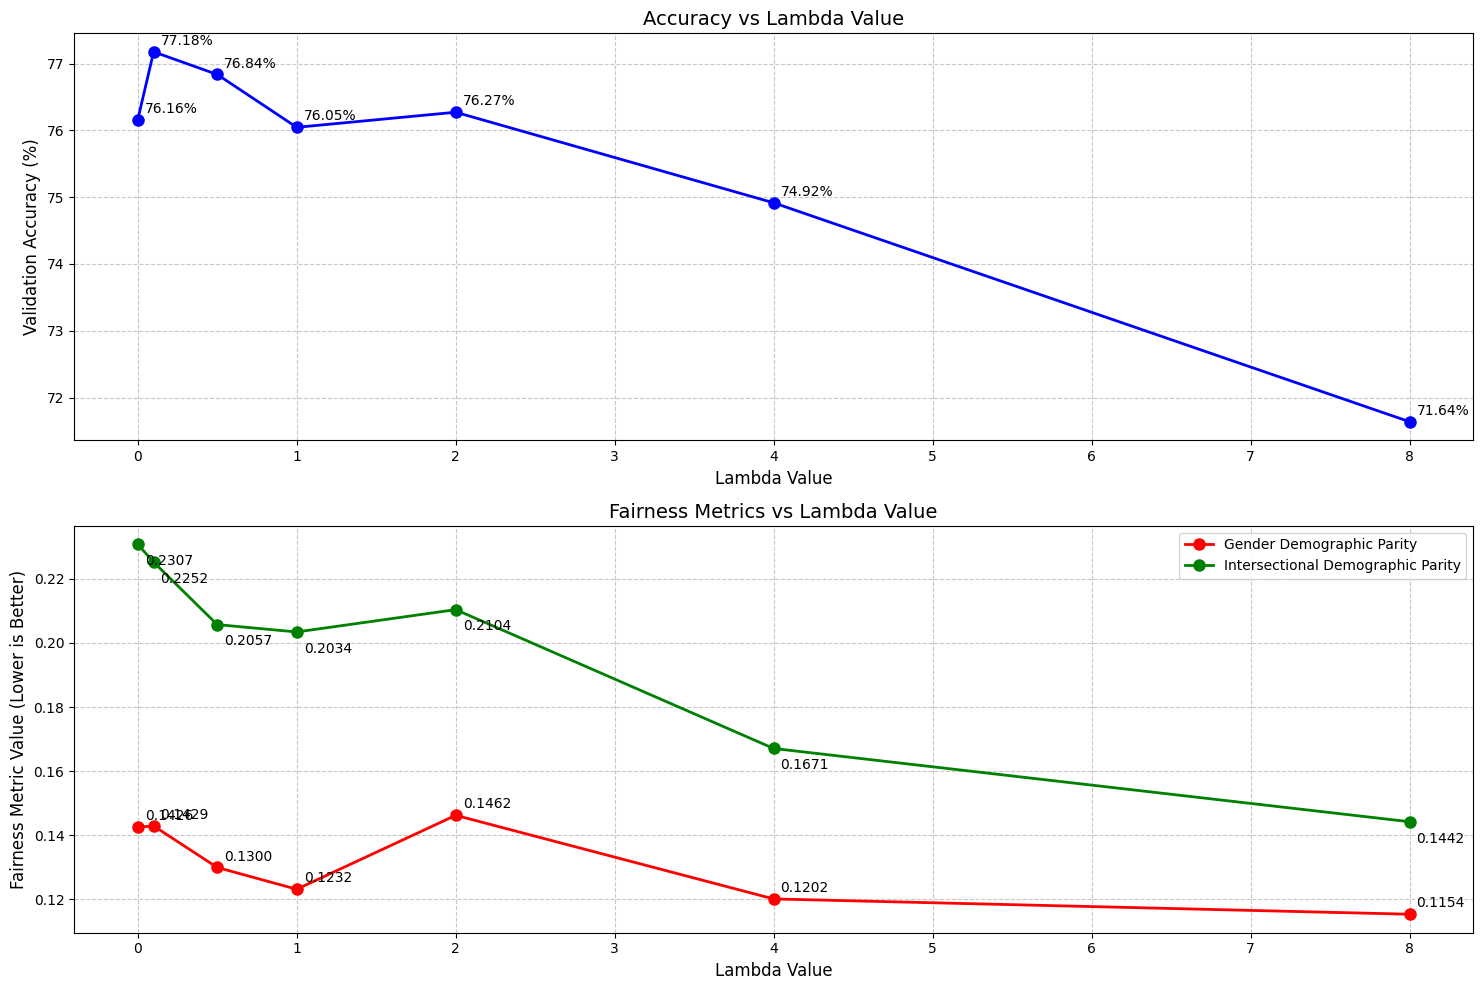

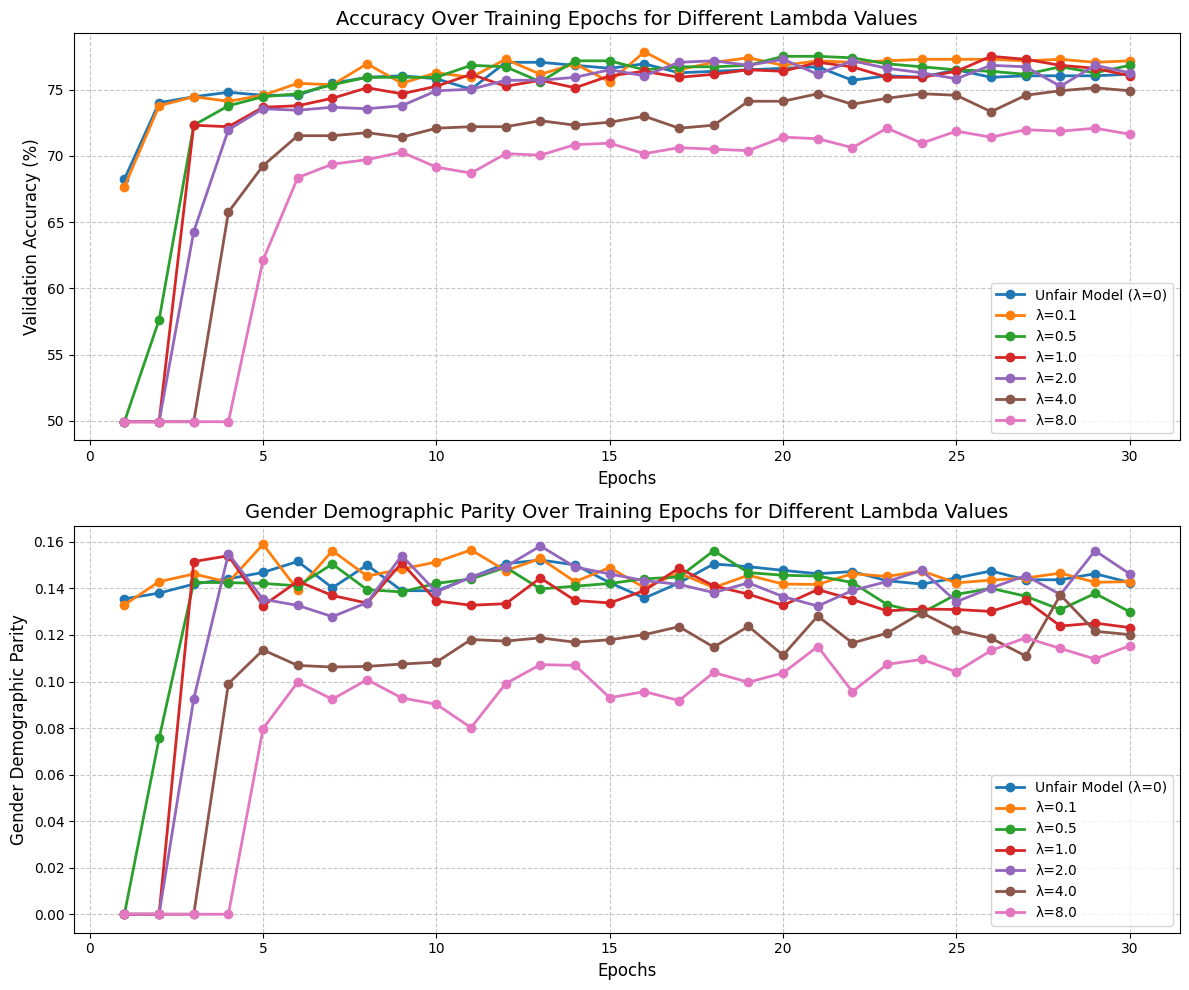

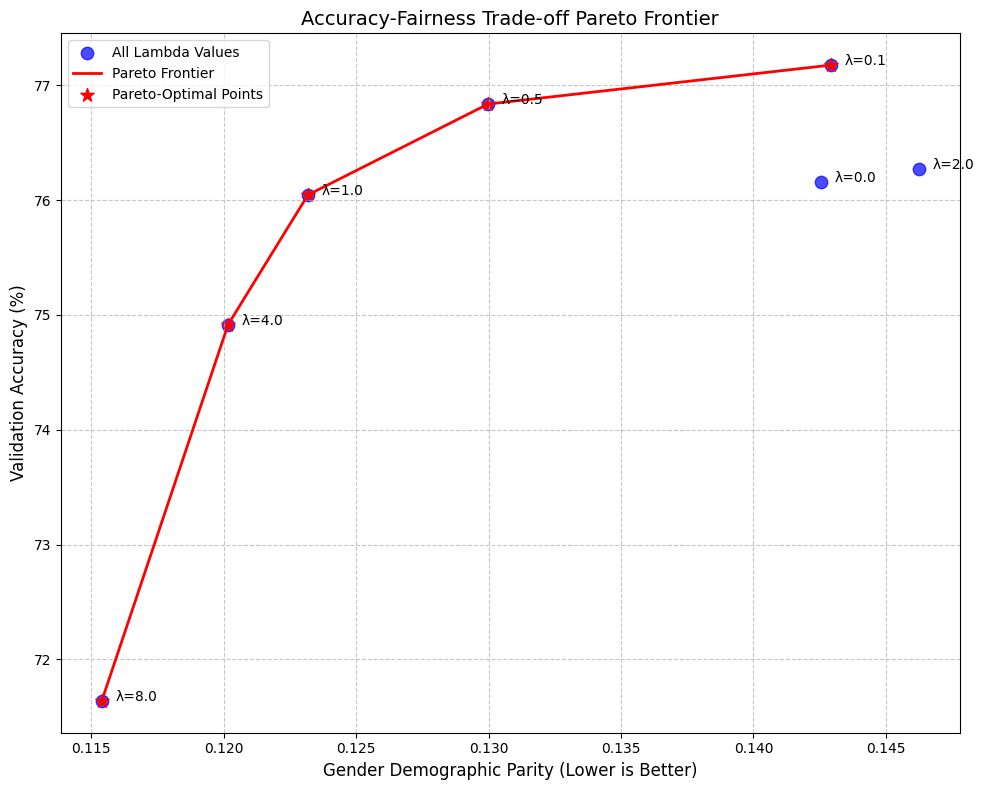


Optimal lambda value based on utility function: 0.5
Utility function used: accuracy - 100 * gender_dp

Recommendations:
- Based on the Pareto frontier analysis, the recommended lambda value is 0.5.
- If you prioritize fairness more, consider using a higher lambda value.
- If you prioritize accuracy more, consider using a lower lambda value.


In [ ]:
def lambda_ablation_study(lambda_values, X, S1, S2, y, num_epochs=30, device='cuda', seed=42):
    """
    Run ablation study with different lambda values.

    Args:
        lambda_values: List of lambda values to test
        X, S1, S2, y: Data tensors
        num_epochs: Number of epochs to train each model
        device: Device to use for training
        seed: Random seed for reproducibility

    Returns:
        results_df: DataFrame with results for each lambda value
        all_metrics: List of MetricsTracker objects for each lambda value
    """
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Split data
    X_train, X_test, S1_train, S1_test, S2_train, S2_test, y_train, y_test = train_test_split(
        X, S1, S2, y, test_size=0.2, random_state=seed, stratify=y
    )

    # Create datasets and dataloaders
    train_dataset = StudentDataset(X_train, S1_train, S2_train, y_train)
    test_dataset = StudentDataset(X_test, S1_test, S2_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Run ablation for each lambda value
    results = []
    all_metrics = []

    # First, train unfair model (lambda=0 effectively)
    print("Training unfair model (lambda=0)...")
    feature_extractor_unfair = FeatureExtractor(X.shape[1], hidden_dim=128).to(device)
    predictor_unfair = Predictor(64).to(device)

    metrics_unfair = train_model(
        feature_extractor_unfair, predictor_unfair,
        train_loader=train_loader, val_loader=test_loader,
        device=device, is_fair_model=False,
        num_epochs=num_epochs
    )

    # Add results for unfair model
    results.append({
        'lambda': 0,
        'accuracy': metrics_unfair.validation_acc[-1],
        'gender_dp': metrics_unfair.demographic_parity[-1],
        'intersectional_dp': metrics_unfair.intersectional_demographic_parity[-1],
    })
    all_metrics.append(metrics_unfair)

    # Then train models with different lambda values
    for lambda_val in lambda_values:
        print(f"\nTraining model with lambda={lambda_val}...")
        feature_extractor = FeatureExtractor(X.shape[1], hidden_dim=128).to(device)
        predictor = Predictor(64).to(device)
        adversary = IntersectionalAdversary(64, output_dims=(2, 2)).to(device)

        metrics = train_model(
            feature_extractor, predictor, adversary,
            train_loader=train_loader, val_loader=test_loader,
            device=device, is_fair_model=True,
            lambda_adv=lambda_val,
            num_epochs=num_epochs
        )

        # Add results for this lambda value
        results.append({
            'lambda': lambda_val,
            'accuracy': metrics.validation_acc[-1],
            'gender_dp': metrics.demographic_parity[-1],
            'intersectional_dp': metrics.intersectional_demographic_parity[-1],
        })
        all_metrics.append(metrics)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df, all_metrics

def plot_lambda_ablation_results(results_df):
    """
    Plot the results of the lambda ablation study.

    Args:
        results_df: DataFrame with results for each lambda value
    """
    plt.figure(figsize=(15, 10))

    # Plot 1: Accuracy vs Lambda
    plt.subplot(2, 1, 1)
    plt.plot(results_df['lambda'], results_df['accuracy'], 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Lambda Value', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.title('Accuracy vs Lambda Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate each point with its value
    for i, row in results_df.iterrows():
        plt.annotate(f"{row['accuracy']:.2f}%",
                    xy=(row['lambda'], row['accuracy']),
                    xytext=(5, 5), textcoords='offset points')

    # Plot 2: Fairness Metrics vs Lambda
    plt.subplot(2, 1, 2)
    plt.plot(results_df['lambda'], results_df['gender_dp'], 'ro-', linewidth=2, markersize=8, label='Gender Demographic Parity')
    plt.plot(results_df['lambda'], results_df['intersectional_dp'], 'go-', linewidth=2, markersize=8, label='Intersectional Demographic Parity')
    plt.xlabel('Lambda Value', fontsize=12)
    plt.ylabel('Fairness Metric Value (Lower is Better)', fontsize=12)
    plt.title('Fairness Metrics vs Lambda Value', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate each point with its value
    for i, row in results_df.iterrows():
        plt.annotate(f"{row['gender_dp']:.4f}",
                    xy=(row['lambda'], row['gender_dp']),
                    xytext=(5, 5), textcoords='offset points')
        plt.annotate(f"{row['intersectional_dp']:.4f}",
                    xy=(row['lambda'], row['intersectional_dp']),
                    xytext=(5, -15), textcoords='offset points')

    plt.tight_layout()
    plt.savefig('lambda_ablation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_metrics_by_lambda(all_metrics, lambda_values):
    """
    Plot the training metrics for each lambda value.

    Args:
        all_metrics: List of MetricsTracker objects for each lambda value
        lambda_values: List of lambda values corresponding to the metrics
    """
    # Include lambda=0 for unfair model
    all_lambda_values = [0] + lambda_values

    # Plot accuracy over epochs for each lambda
    plt.figure(figsize=(12, 10))

    # Plot 1: Accuracy over epochs
    plt.subplot(2, 1, 1)
    for i, metrics in enumerate(all_metrics):
        lambda_val = all_lambda_values[i]
        label = f"λ={lambda_val}" if lambda_val > 0 else "Unfair Model (λ=0)"
        epochs = range(1, len(metrics.validation_acc) + 1)
        plt.plot(epochs, metrics.validation_acc, 'o-', linewidth=2, label=label)

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.title('Accuracy Over Training Epochs for Different Lambda Values', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Gender Demographic Parity over epochs
    plt.subplot(2, 1, 2)
    for i, metrics in enumerate(all_metrics):
        lambda_val = all_lambda_values[i]
        label = f"λ={lambda_val}" if lambda_val > 0 else "Unfair Model (λ=0)"
        epochs = range(1, len(metrics.demographic_parity) + 1)
        plt.plot(epochs, metrics.demographic_parity, 'o-', linewidth=2, label=label)

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Gender Demographic Parity', fontsize=12)
    plt.title('Gender Demographic Parity Over Training Epochs for Different Lambda Values', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('training_metrics_by_lambda.png', dpi=300, bbox_inches='tight')
    plt.show()

def calculate_pareto_frontier(results_df):
    """
    Calculate the Pareto frontier for the accuracy-fairness trade-off.

    Args:
        results_df: DataFrame with results for each lambda value

    Returns:
        pareto_df: DataFrame with Pareto-optimal points
    """
    pareto_points = []
    all_points = results_df[['lambda', 'accuracy', 'gender_dp']].values

    for i, (lambda_val, accuracy, gender_dp) in enumerate(all_points):
        is_dominated = False
        for j, (_, other_accuracy, other_gender_dp) in enumerate(all_points):
            if i != j:
                # Point j dominates point i if it has higher accuracy and lower gender_dp
                if other_accuracy >= accuracy and other_gender_dp <= gender_dp:
                    if other_accuracy > accuracy or other_gender_dp < gender_dp:
                        is_dominated = True
                        break

        if not is_dominated:
            pareto_points.append({
                'lambda': lambda_val,
                'accuracy': accuracy,
                'gender_dp': gender_dp
            })

    pareto_df = pd.DataFrame(pareto_points)
    return pareto_df.sort_values('gender_dp')

def plot_pareto_frontier(results_df, pareto_df):
    """
    Plot the Pareto frontier for the accuracy-fairness trade-off.

    Args:
        results_df: DataFrame with results for each lambda value
        pareto_df: DataFrame with Pareto-optimal points
    """
    plt.figure(figsize=(10, 8))

    # Plot all points
    plt.scatter(results_df['gender_dp'], results_df['accuracy'],
               c='blue', s=80, alpha=0.7, label='All Lambda Values')

    # Annotate each point with its lambda value
    for i, row in results_df.iterrows():
        plt.annotate(f"λ={row['lambda']}",
                    xy=(row['gender_dp'], row['accuracy']),
                    xytext=(10, 0), textcoords='offset points')

    # Plot Pareto frontier
    plt.plot(pareto_df['gender_dp'], pareto_df['accuracy'], 'r-', linewidth=2, label='Pareto Frontier')
    plt.scatter(pareto_df['gender_dp'], pareto_df['accuracy'],
               c='red', s=100, marker='*', label='Pareto-Optimal Points')

    plt.xlabel('Gender Demographic Parity (Lower is Better)', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.title('Accuracy-Fairness Trade-off Pareto Frontier', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('pareto_frontier.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_ablation_study():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, S1, S2, y = preprocess_data('data.csv')
    print(f"Data shape: X={X.shape}, S1={S1.shape}, S2={S2.shape}, y={y.shape}")

    # Define lambda values to test (including original value and both smaller and larger values)
    lambda_values = [0.1, 0.5, 1.0, 2.0, 4.0, 8.0]

    # Run ablation study
    results_df, all_metrics = lambda_ablation_study(
        lambda_values=lambda_values,
        X=X, S1=S1, S2=S2, y=y,
        num_epochs=30,  # Reduced for faster experimentation
        device=device
    )

    # Print results table
    print("\nAblation Study Results:")
    print(results_df.to_string(index=False))

    # Plot results
    plot_lambda_ablation_results(results_df)
    plot_training_metrics_by_lambda(all_metrics, lambda_values)

    # Calculate and plot Pareto frontier
    pareto_df = calculate_pareto_frontier(results_df)
    plot_pareto_frontier(results_df, pareto_df)

    # Find optimal lambda based on Pareto frontier and desired trade-off
    # You could define a custom utility function here based on your preferences
    # For example, a simple weighted sum: utility = accuracy - 100 * gender_dp
    results_df['utility'] = results_df['accuracy'] - 100 * results_df['gender_dp']
    optimal_lambda = results_df.loc[results_df['utility'].idxmax()]['lambda']

    print(f"\nOptimal lambda value based on utility function: {optimal_lambda}")
    print("Utility function used: accuracy - 100 * gender_dp")

    # Provide recommendations
    print("\nRecommendations:")
    print(f"- Based on the Pareto frontier analysis, the recommended lambda value is {optimal_lambda}.")
    print("- If you prioritize fairness more, consider using a higher lambda value.")
    print("- If you prioritize accuracy more, consider using a lower lambda value.")

    return results_df, all_metrics, pareto_df

if __name__ == "__main__":
    run_ablation_study()